Starting Carbon Credit Verification Process...
Analyzing project site...


/opt/anaconda3/lib/python3.12/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Visualizing results...


Map(center=[-1.3117000016581204, 35.26180000001454], controls=(WidgetControl(options=['position', 'transparent…

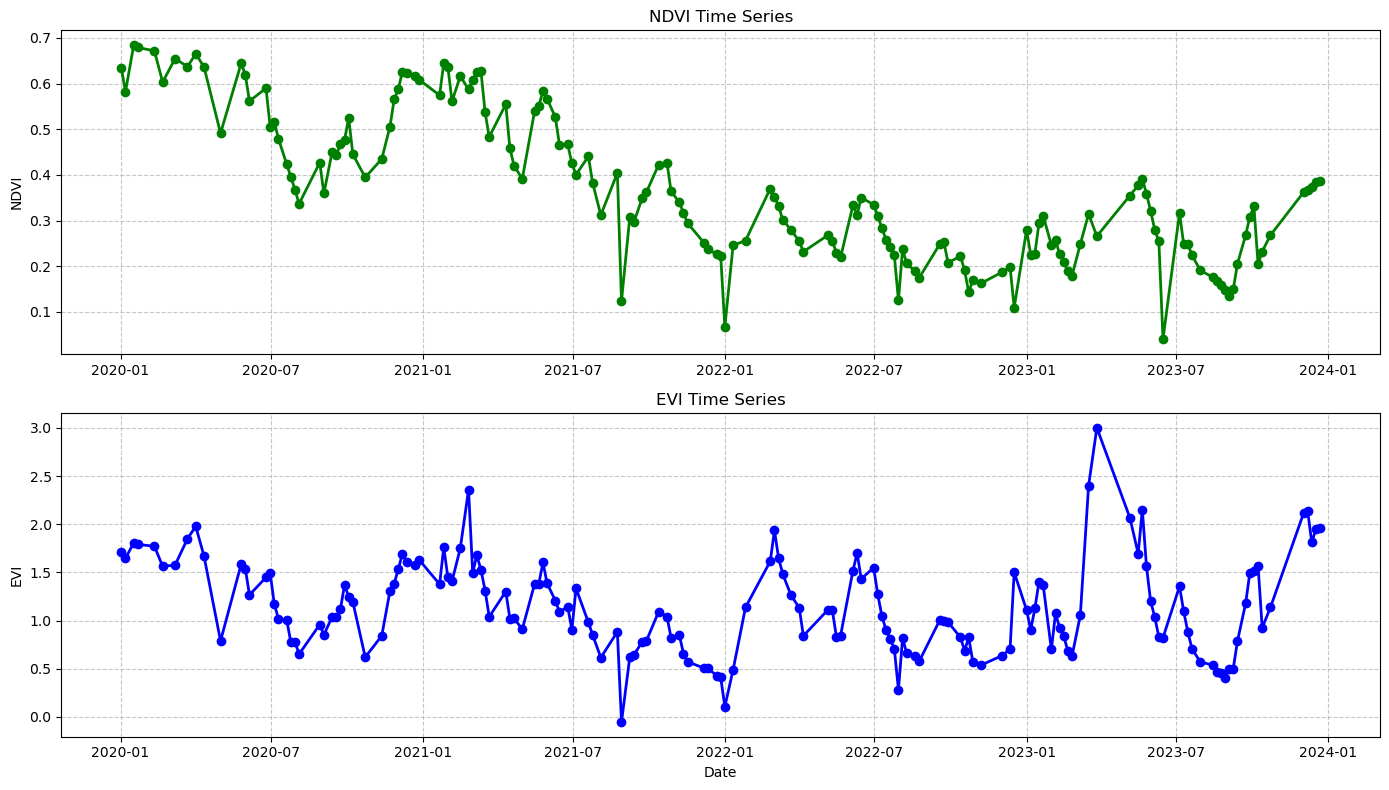


----- Verification Results -----
Verified: No
Carbon Credits: 0 tCO2e
NDVI Change: -0.2475
Project Area: 123.61 hectares
Reason: Insufficient vegetation growth or area was already forested.
Verification process completed!


In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap

# Authenticate and initialize Earth Engine
try:
    ee.Initialize(project='smooth-kiln-449317-f7.')
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='smooth-kiln-449317-f7')

# Function to get and prepare Sentinel-2 imagery
def get_sentinel_imagery(start_date, end_date, aoi):
    """
    Retrieves Sentinel-2 imagery for the given time period and area of interest.
    Applies cloud filtering and calculates vegetation indices.
    """
    # Import Sentinel-2 Surface Reflectance collection
    s2_collection = ee.ImageCollection("COPERNICUS/S2_SR") \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

    # Function to add spectral indices to an image
    def add_indices(image):
        # Normalized Difference Vegetation Index (NDVI)
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Enhanced Vegetation Index (EVI)
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }).rename('EVI')

        # Soil Adjusted Vegetation Index (SAVI)
        savi = image.expression(
            '((NIR - RED) / (NIR + RED + 0.5)) * (1.5)',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4')
            }).rename('SAVI')

        return image.addBands([ndvi, evi, savi])

    # Map the function over the collection
    return s2_collection.map(add_indices)

# Analyze time series data
def analyze_time_series(site, start_date, end_date):
    """
    Analyzes vegetation indices over time for a specific site.
    Returns a time series of NDVI, EVI, and SAVI values.
    """
    # Get imagery collection for the time period
    imagery = get_sentinel_imagery(start_date, end_date, site)

    # Create a time series of vegetation indices
    def extract_index_value(image):
        # Calculate mean values for the site
        ndvi_mean = image.select('NDVI').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=site,
            scale=10
        ).get('NDVI')

        evi_mean = image.select('EVI').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=site,
            scale=10
        ).get('EVI')

        savi_mean = image.select('SAVI').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=site,
            scale=10
        ).get('SAVI')

        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'NDVI': ndvi_mean,
            'EVI': evi_mean,
            'SAVI': savi_mean
        })

    # Map over the image collection
    time_series = imagery.map(extract_index_value)

    # Convert to a pandas DataFrame
    time_series_list = time_series.reduceColumns(ee.Reducer.toList(4), ['date', 'NDVI', 'EVI', 'SAVI']).get('list').getInfo()

    # Create DataFrame
    df = pd.DataFrame(time_series_list, columns=['date', 'NDVI', 'EVI', 'SAVI'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    return df

# Simplified verification function
def verify_carbon_credits(project_site, start_date, end_date):
    """
    Verifies carbon credits for a project site using direct vegetation index analysis.
    Returns verification results.
    """
    # Analyze time series data
    time_series_df = analyze_time_series(project_site, start_date, end_date)

    # Calculate basic verification metrics
    ndvi_start = time_series_df.iloc[0]['NDVI']
    ndvi_end = time_series_df.iloc[-1]['NDVI']
    ndvi_change = ndvi_end - ndvi_start

    # Calculate area in hectares
    area_m2 = project_site.area().getInfo()
    area_ha = area_m2 / 10000

    # Calculate time difference in years
    start_date_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    years_diff = (end_date_dt - start_date_dt).days / 365.25

    # Simple verification logic based on NDVI change
    if ndvi_change > 0.2 and ndvi_start < 0.3:
        verified = True
        carbon_rate = 8  # tCO2e per hectare per year
    elif ndvi_change > 0.1:
        verified = True
        carbon_rate = 5  # tCO2e per hectare per year
    else:
        verified = False
        carbon_rate = 0

    carbon_credits = area_ha * carbon_rate * years_diff

    # Return verification results
    return {
        'verified': verified,
        'ndvi_start': float(ndvi_start),
        'ndvi_end': float(ndvi_end),
        'ndvi_change': float(ndvi_change),
        'carbon_credits': round(carbon_credits),
        'area_ha': area_ha,
        'time_series_data': time_series_df.to_dict('records'),
        'reason': None if verified else "Insufficient vegetation growth or area was already forested."
    }

# Visualize results
def visualize_verification_results(results, project_site):
    """
    Visualizes the verification results with maps and charts.
    """
    # Create a map
    m = geemap.Map()
    m.centerObject(project_site, 13)

    # Get the date range from results
    start_date = results['time_series_data'][0]['date']
    end_date = results['time_series_data'][-1]['date']

    # Add median composite from the collection
    s2_collection = ee.ImageCollection("COPERNICUS/S2_SR") \
        .filterDate(start_date, end_date) \
        .filterBounds(project_site) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

    # Add median composite
    m.addLayer(s2_collection.median().clip(project_site),
               {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000},
               'RGB Composite')

    # Add NDVI layer from the most recent image
    recent_image = s2_collection.sort('system:time_start', False).first()
    ndvi = recent_image.normalizedDifference(['B8', 'B4']).clip(project_site)

    ndvi_palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163',
                   '99B718', '74A901', '66A000', '529400', '3E8601',
                   '207401', '056201', '004C00', '023B01', '012E01',
                   '011D01', '011301']

    m.addLayer(ndvi, {'min': 0, 'max': 1, 'palette': ndvi_palette}, 'NDVI')

    # Add the project site boundary
    m.addLayer(project_site, {'color': 'red'}, 'Project Boundary')

    # Display the map
    display(m)

    # Plot time series data
    plt.figure(figsize=(14, 8))

    # Convert dates back to datetime if they are strings
    time_series_df = pd.DataFrame(results['time_series_data'])
    if isinstance(time_series_df['date'][0], str):
        time_series_df['date'] = pd.to_datetime(time_series_df['date'])

    # Plot NDVI time series
    plt.subplot(2, 1, 1)
    plt.plot(time_series_df['date'], time_series_df['NDVI'], 'g-', marker='o', linewidth=2)
    plt.title('NDVI Time Series')
    plt.ylabel('NDVI')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot EVI time series
    plt.subplot(2, 1, 2)
    plt.plot(time_series_df['date'], time_series_df['EVI'], 'b-', marker='o', linewidth=2)
    plt.title('EVI Time Series')
    plt.xlabel('Date')
    plt.ylabel('EVI')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Display verification results
    print("\n----- Verification Results -----")
    print(f"Verified: {'Yes' if results['verified'] else 'No'}")
    print(f"Carbon Credits: {results['carbon_credits']} tCO2e")
    print(f"NDVI Change: {results['ndvi_change']:.4f}")
    print(f"Project Area: {results['area_ha']:.2f} hectares")

    if not results['verified']:
        print(f"Reason: {results['reason']}")

# Main function to run the verification process
def main():
    """
    Main function to execute the simplified carbon credit verification process.
    """
    print("Starting Carbon Credit Verification Process...")

    # Define time period
    start_date = '2020-01-01'
    end_date = '2023-12-31'

    # Define a project site to verify
    project_site = ee.Geometry.Polygon([
        [35.2568, -1.3067],
        [35.2668, -1.3067],
        [35.2668, -1.3167],
        [35.2568, -1.3167],
        [35.2568, -1.3067]
    ])

    # Verify carbon credits for the project site
    print("Analyzing project site...")
    verification_results = verify_carbon_credits(
        project_site,
        start_date,
        end_date
    )

    # Visualize the results
    print("Visualizing results...")
    visualize_verification_results(verification_results, project_site)

    print("Verification process completed!")

# Run the main function
if __name__ == "__main__":
    main() 